# Load libraries

In [14]:
# pip install tqdm networkx plotly matplotlib pandas jinja2 kaleido
# pip install --upgrade nbformat
import os
from tqdm import tqdm
from codes.bb import *
import pandas as pd
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Exploring data

In [3]:
# read nrm files
nmr_folder = 'data/nmr_spec'
df_nmr = {'fn': [], 'i': [], 'j': [], 'dij': []}
for fn in tqdm(os.listdir(nmr_folder)):
    if not fn.endswith('.nmr'):
        continue
    fn = os.path.join(nmr_folder, fn)
    with open(fn, 'r') as fd:
        for edge in fd:
            i, j, dij = edge.split()[:3]
            # parse the edge
            i, j, dij = int(i), int(j), float(dij)
            # add the edge
            df_nmr['fn'].append(fn)
            df_nmr['i'].append(i)
            df_nmr['j'].append(j)
            df_nmr['dij'].append(dij)
# convert to dataframe
df_nmr = pd.DataFrame(df_nmr)
# add columns for dmax, pdb and chain
df_nmr['DMAX'] = df_nmr['fn'].apply(lambda fn: int(fn.split('dmax_')[1].split('.')[0]))
df_nmr['PDB'] = df_nmr['fn'].apply(lambda fn: fn.split('/')[-1].split('_')[0])
df_nmr['chain'] = df_nmr['fn'].apply(lambda fn: fn.split('/')[-1].split('_')[2])

100%|██████████| 13/13 [00:00<00:00, 211.84it/s]


In [4]:
def get_lenS(fnmr):
    flog = fnmr.replace('.nmr', '.log')
    with open(flog, 'r') as fd:
        for row in fd:
            if '> lenS' in row:
                return int(row.split()[-1])
# columns of interest
cols = ['PDB','DMAX','i','j','fn']
dfA = df_nmr[cols].groupby(['PDB','DMAX']).agg({'i':'count', 'j':'max', 'fn':'max'}).reset_index()
dfA.rename(columns={'i':'|E|', 'j':'|V|'}, inplace=True)
# dict of dataframes, one for each dmax
df_DMAX = {dmax:None for dmax in dfA['DMAX'].unique()} 
for dmax in df_DMAX:
    df_DMAX[dmax] = dfA[dfA['DMAX'] == dmax].groupby(['PDB','|V|']).max().reset_index()
    # rename columns
    df_DMAX[dmax].rename(columns={'|E|':f'|E_{dmax}|','fn':f'|S_{dmax}|'}, inplace=True)
    # parse the log file to get the length of S
    df_DMAX[dmax][f'|S_{dmax}|'] = df_DMAX[dmax][f'|S_{dmax}|'].apply(get_lenS)
    # drop redundant columns
    if dmax == min(df_DMAX):
        df_DMAX[dmax].drop(columns=['DMAX'], inplace=True)
    else:
        df_DMAX[dmax].drop(columns=['DMAX','|V|'], inplace=True)
# merge all dataframes
dfB = df_DMAX[min(df_DMAX)]
for dmax in df_DMAX:
    if dmax == min(df_DMAX):
        continue
    dfB = pd.merge(dfB, df_DMAX[dmax], on=['PDB'])
# sort by |V|
df_DMAX = dfB.sort_values(by=['|V|'])
cols = df_DMAX.columns.tolist()
# change df_MAX column order
cols = cols[:2] + sorted(cols[2:])
df_DMAX = df_DMAX[cols]
# convert to latex
tex = df_DMAX.to_latex(index=False,
                column_format='lrrc',
                header=cols, # list of column names
                escape=False,
                caption=f'Number of nodes and edges for each instance.',
                label=f'tab:instances',
                multicolumn=False,
                multicolumn_format='c')
# save tex to file
with open('latex/tables/instances.tex', 'w') as fd:
    fd.write(tex)
# display
df_DMAX

FileNotFoundError: [Errno 2] No such file or directory: 'data/nmr_spec/test189_chain_A_dmax_5.log'

In [131]:
# |s| is the number of edges covering the segment s
df = {'PDB':[], 'DMAX':[], 'sid':[], '|s|':[]}
for fn in tqdm(os.listdir(nmr_folder)):
    # skip non-dmp files
    if not fn.endswith('.dmp'):
        continue
    # get pdb and dmax
    pdb = fn.split('_')[0]
    dmax = int(fn.split('dmax_')[1].split('.')[0])
    fn = os.path.join(nmr_folder, fn)
    with open(fn, 'r') as fd:
        reading = False # flag to start reading
        for row in fd:
            if 'segments [sid i j weight EID]:' in row:
                reading = True
                continue
            if 'E [idx eid i j SID]:' in row:
                break
            if reading:
                v = [int(s) for s in row.split()]
                sid, i, j = int(v[0]), int(v[1]), int(v[2])                
                df['PDB'].append(pdb)
                df['DMAX'].append(dmax)
                df['|s|'].append(len(v)-4)
                df['sid'].append(sid)
df = pd.DataFrame(df)
dfA = df.groupby(['DMAX']).agg({'|s|':'max'}).reset_index().sort_values(by=['DMAX'])
dfA.rename(columns={'|s|':'|s|_max'}, inplace=True)
print(dfA)


100%|██████████| 147/147 [00:00<00:00, 32226.78it/s]

   DMAX  |s|_max
0     5        5


In [132]:
fig = go.Figure()
for dmax in df['DMAX'].unique():
    dfB = df[df['DMAX'] == dmax].sort_values(by=['|s|'])
    y, PDB, SID = dfB['|s|'], dfB['PDB'], dfB['sid']
    x = np.arange(1, len(y)+1) / len(y)    
    fig.add_trace(go.Scatter(x=x, y=y, name=f'dmax={dmax}'))
    # add pdb to the hover text
    fig.data[-1].text = [f'{pdb}, sid:{sid}' for pdb, sid in zip(PDB, SID)]
# Overlay both histograms
fig.update_layout(barmode='overlay')
# xlim
fig.update_xaxes(range=[0, 1.05])
# set title
fig.update_layout(title_text='CDF of number of edges per segment')
# set x-axis title
fig.update_xaxes(title_text='CDF')
# set y-axis title
fig.update_yaxes(title_text='Number of edges on a given segment', type="log")
fig.show()

# Exploring results:

## Results: data/nmr_spec

In [15]:
nmr_folder = 'data/nmr_spec'
# run read_results.py
os.system('python read_results.py -wdir ' + nmr_folder)
# read results
df = pd.read_csv(os.path.join(nmr_folder, 'results.csv'))
print('tmax (secs) =', df['tmax'].unique())
print('')
# add columns
df['PDB'] = df.apply(lambda row: row['fnmr'].split('/')[-1].split('_')[0], axis=1)
# set columns order
cols = ['PDB','|V|','|E|','|S|','costRX', 'costGD', 'costSB']
cols += sorted([c for c in df.columns if c not in cols])
df = df[cols]
# set columns names
cols = df.columns.tolist()
cols = {c:c.replace('cost', '') for c in cols}
df.rename(columns=cols, inplace=True)
# sort by |S|
df = df.sort_values(by=['|S|'])
# remove unnecessary columns
cols = ['fnmr', 'clean_log', 'verbose', 'dump', 'tmax']
cols += [c for c in df.columns if c.startswith('time')]
cols += [c for c in df.columns if c.startswith('cost')]
df.drop(columns=cols, inplace=True)
# display
caption = 'Table of costs for each instance.'
print(caption)
pd.set_option('display.float_format', lambda x: '%g' % x)
dfA = df.groupby('PDB').max().reset_index()
# remove col solver
dfA.drop(columns=['solver'], inplace=True)
display(dfA)
# convert to latex
tex = dfA.to_latex(index=False,
                column_format='lrrrrrrrrr',
                header=dfA.columns, # list of column names
                escape=False,
                caption=caption,
                label=f'tab:costs',
                multicolumn=False,
                multicolumn_format='c')
# save tex to file
wdir = os.path.join('latex',nmr_folder)
if not os.path.exists(wdir):
    os.mkdir(wdir)
with open(os.path.join(wdir,'costs.tex'), 'w') as fd:
    fd.write(tex)

Parameters:
   wdir = data/nmr_spec

Getting log files from wdir=data/nmr_spec
Saving results to data/nmr_spec/results.csv
tmax (secs) = [3600]

Table of costs for each instance.


,PDB,|V|,|E|,|S|,RX,GD,SB,BB,BF
0,testA,20,5,7,52,158,1040,158,158
1,testB,20,5,7,92,136,198,92,92
2,testC,20,5,8,58,116,138,96,96


In [17]:
dfA = {'PDB':[],'cost':[], 'algorithm':[]}
for i, row in df.iterrows():
    for c in df.columns:
        if c in ['PDB','|V|','|E|','|S|']:
            continue
        dfA['PDB'].append(row['PDB'])
        dfA['cost'].append(row[c])
        dfA['algorithm'].append(c)
dfA = pd.DataFrame(dfA)
# remove solver
dfA = dfA[dfA['algorithm']!='solver']
# remove nan
dfA = dfA[~dfA['cost'].isna()]
# remove duplicates
dfA = dfA.drop_duplicates(subset=['PDB','algorithm'])
# show
fig = px.bar(dfA, x='PDB', y='cost', color='algorithm', title='Costs per instance', barmode='group', log_y=True, text='cost')
# fig.update_yaxes(range=[1e-2, 1e4])
fig.update_traces(textposition='auto') # set text position
fig.show()
# save fig to file
wdir = os.path.join('latex',nmr_folder)
if not os.path.exists(wdir):
    os.mkdir(wdir)
fig.write_image(os.path.join(wdir,'costs.pdf'))

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


prune edges: [(1, 13), (5, 17), (7, 16), (7, 19), (14, 20)]
data/nmr_spec/testA_chain_A_dmax_5.nmr


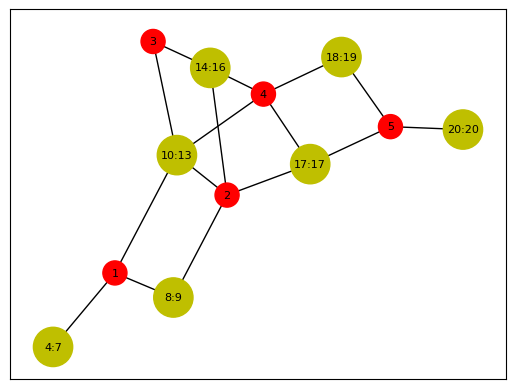

prune edges: [(2, 10), (4, 17), (8, 20), (14, 19), (16, 20)]
data/nmr_spec/testB_chain_A_dmax_5.nmr


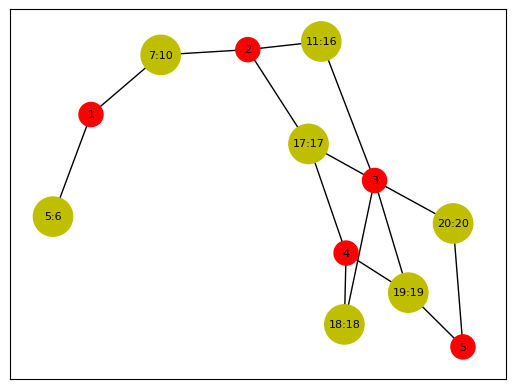

prune edges: [(1, 11), (3, 17), (6, 10), (6, 18), (14, 20)]
data/nmr_spec/testC_chain_A_dmax_5.nmr


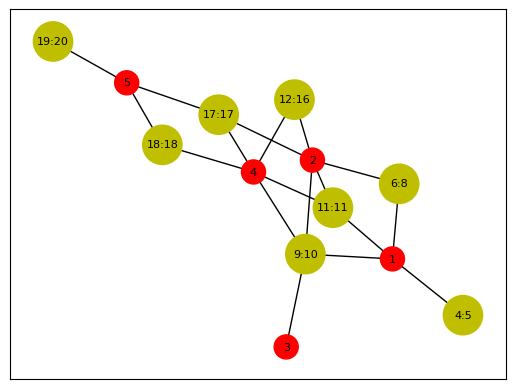

In [18]:
def plot_graph(G, fnmr, savefig=False):
    print(fnmr)
    pos = nx.spring_layout(G)    
    node_color = ['y' if ':' in node else 'r' for node in G.nodes()]
    node_size = [800 if ':' in node else 300 for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, 
        node_size=node_size, 
        node_shape='o', 
        node_color=node_color)
    nx.draw_networkx_labels(G, pos, font_color='k', font_size=8)
    nx.draw_networkx_edges(G, pos)
    if savefig:
        plt.savefig(fnmr.replace('.nmr', '.pdf'), format='pdf')
    plt.show()

# plot graphs
for fn in sorted(os.listdir(nmr_folder)):
    if not fn.endswith('.nmr'):
        continue
    fn = os.path.join(nmr_folder, fn)
    nmr = NMR(fn)
    E, S = nmr.E, nmr.S # edges and segments
    G = nmr.ordering_graph # ordering graph
    print('prune edges:', [(e.i, e.j) for e in nmr.pruneEdges])
    plot_graph(G, fn, True)

## Results: data/nmr

In [35]:
nmr_folder = 'data/nmr/'

# run read_results.py
os.system('python read_results.py -wdir ' + nmr_folder)

df = pd.read_csv(os.path.join(nmr_folder, 'results.csv'))

# extract DMAX and PDB ID from fnmr
df['PDB'] = df['fnmr'].apply(lambda x: x.split('/')[-1].split('_')[0].replace('.nmr', ''))
df['DMAX'] = df['fnmr'].apply(lambda x: x.split('_')[-1].replace('.nmr',''))

print('tmax: ', df['tmax'].unique())
print('DMAX: ', df['DMAX'].unique())
print('timeoutBF: ', df['timeoutBF'].unique())
print('timeoutBB: ', df['timeoutBB'].unique())

# drop rows with solver=='BF', because BF got timeout and we don't have the cost
df = df[df['solver'] != 'BF']

# drop unnecessary columns
cols = ['fnmr', 'clean_log', 'verbose', 'dump', 'tmax', 'timeBF', 'costBF','timeoutBF','timeGD','timeSB','solver']
df.drop(columns=cols, inplace=True)

# # set column order
cols = [
    'PDB', 'DMAX', 
    '|V|', '|E|', '|S|',
    'costRX', 'costGD', 'costSB', 'costBB', 
    'timeBB',  'timeoutBB',
]
df = df[cols]

# sort by DMAX and nnodes
df = df.sort_values(by=['DMAX', '|V|'])

df.head()

Parameters:
   wdir = data/nmr/

Getting log files from wdir=data/nmr/
Saving results to data/nmr/results.csv
tmax:  [3600]
DMAX:  ['4' '5' '6' '7']
timeoutBF:  [ 1. nan]
timeoutBB:  [nan  0.  1.]


,PDB,DMAX,|V|,|E|,|S|,costRX,costGD,costSB,costBB,timeBB,timeoutBB
123,1n6t,4,30,16,14,44.0,44.0,44.0,44.0,0.0,0.0
73,1fw5,4,60,48,39,104.0,104.0,104.0,104.0,0.0,0.0
44,1adx,4,120,36,50,1342.0,590446.0,2163816.0,2163306.0,3601.0,1.0
119,1bdo,4,240,56,97,2824.0,536948576.0,66998.0,66998.0,3601.0,1.0
91,1all,4,480,284,269,864.0,1342.0,1342.0,1342.0,3601.0,1.0


In [38]:
dfA = df[['PDB','DMAX']].groupby(['PDB']).count().reset_index()
dfA_min = dfA['DMAX'].min()
dfA_max = dfA['DMAX'].max()
DMAX = df['DMAX'].unique()
print('Global Parameters:')
print(f'   - Number of PDB: {len(dfA)}')
print(f'   - DMAX: {df["DMAX"].unique()}')
print(f'   - (Min, Max) numbers of rows per PDB: {dfA_min, dfA_max}')

Global Parameters:
   - Number of PDB: 17
   - DMAX: ['4' '5' '6' '7']
   - (Min, Max) numbers of rows per PDB: (4, 4)


In [39]:
# Group by DMAX
dfA = df.copy()
df_DMAX = {}
for k, dmax in enumerate(DMAX):
    dfB = dfA[dfA['DMAX'] == dmax].copy()
    df_DMAX[dmax] = dfB
    # remove unwanted columns
    if k > 0:
        df_DMAX[dmax].drop(columns=['|V|'], inplace=True)
    df_DMAX[dmax].drop(columns=['DMAX'], inplace=True)
    # rename columns
    cols = {col:f'{col}_{dmax}' for col in dfB.columns if col not in ['PDB','|V|']}
    for col, colname in cols.items():
        if '|_' in colname:
            cols[col] = f'{col[:-1]}_{dmax}|'
    df_DMAX[dmax].rename(columns=cols, inplace=True)
# merge all dataframes
dfB = df_DMAX[min(df_DMAX)]
for dmax in df_DMAX:
    if dmax == min(df_DMAX):
        continue
    dfB = pd.merge(dfB, df_DMAX[dmax], on=['PDB'])
df_DMAX = dfB
# change columns order
cols = list(dfB.columns)

# display
df_DMAX.columns

Index(['PDB', '|V|', '|E_4|', '|S_4|', 'costRX_4', 'costGD_4', 'costSB_4',
       'costBB_4', 'timeBB_4', 'timeoutBB_4', '|E_5|', '|S_5|', 'costRX_5',
       'costGD_5', 'costSB_5', 'costBB_5', 'timeBB_5', 'timeoutBB_5', '|E_6|',
       '|S_6|', 'costRX_6', 'costGD_6', 'costSB_6', 'costBB_6', 'timeBB_6',
       'timeoutBB_6', '|E_7|', '|S_7|', 'costRX_7', 'costGD_7', 'costSB_7',
       'costBB_7', 'timeBB_7', 'timeoutBB_7'],
      dtype='object')

In [40]:
# table of number of vertices, edges and segments for each PDB
cols = ['PDB', '|V|']
cols += sorted([c for c in df_DMAX.columns if ('|' in c) and ('_') in c])
df_DMAX[cols]


,PDB,|V|,|E_4|,|E_5|,|E_6|,|E_7|,|S_4|,|S_5|,|S_6|,|S_7|
0,1n6t,30,16,92,152,175,14,27,27,27
1,1fw5,60,48,243,384,463,39,57,57,57
2,1adx,120,36,305,654,1032,50,117,117,117
3,1bdo,240,56,625,1437,2168,97,237,237,237
4,1all,480,284,2009,3498,4542,269,477,477,477
5,6s61,516,275,2042,3606,4811,273,513,513,513
6,1fhl,1002,435,3378,6811,10086,540,999,999,999
7,4wua,1032,447,3402,6612,9494,538,1027,1028,1029
8,6czf,1494,552,4747,9687,14389,697,1491,1491,1491
9,5ijn,1950,761,6137,12422,18171,917,1941,1944,1945


In [54]:
# table of cost for each instance and each algorithm
for dmax in DMAX:
    cols = ['PDB'] + sorted([c for c in df_DMAX.columns if ('cost' in c) and (f'_{dmax}' in c)])    
    dfA = df_DMAX[cols].copy()
    dfA.rename(columns={col:col.split('_')[0].replace('cost','') for col in dfA.columns}, inplace=True)
    cols = ['PDB', 'RX', 'GD', 'SB']
    cols += [c for c in dfA.columns if c not in cols]
    dfA = dfA[cols]    
    dfA['timeoutBB'] = df_DMAX[f'timeoutBB_{dmax}'].astype(bool)
    # replace numbers smaller than zero by nan
    dfA[cols[2:]] = dfA[cols[2:]].applymap(lambda x: np.nan if x < 0 else x)    
    print(f'Cost for DMAX={dmax}')
    # set display options for float precision, only for dfA
    pd.set_option('display.float_format', lambda x: '%.3g' % x)
    # scaling by min cost
    dfA['cost_min'] = dfA[cols[2:]].min(axis=1)
    dfA[['RX','GD','SB','BB']] = dfA[['RX','GD','SB','BB']].div(dfA['cost_min'], axis=0)    
    display(dfA)

Cost for DMAX=4


,PDB,RX,GD,SB,BB,timeoutBB,cost_min
0,1n6t,1,1,1,1,False,44
1,1fw5,1,1,1,1,False,104
2,1adx,0.00227,1,3.66,3.66,True,5.9e+05
3,1bdo,0.0422,8.01e+03,1,1,True,6.7e+04
4,1all,0.644,1,1,1,True,1.34e+03
5,6s61,0.998,1,1,1,True,854
6,1fhl,NaN,NaN,NaN,NaN,True,NaN
7,4wua,0.000102,12,1,1,True,6.74e+07
8,6czf,3.72,1.48e+03,1,1,True,7.51e+05
9,5ijn,20,1,1.66,1.66,True,2.7e+07


Cost for DMAX=5


,PDB,RX,GD,SB,BB,timeoutBB,cost_min
0,1n6t,1,1,1,1,False,54
1,1fw5,1,1,1,1,False,114
2,1adx,1,1,1,1,False,234
3,1bdo,1,1,1,1,False,474
4,1all,1,1,1,1,False,954
5,6s61,1,1,1,1,False,1.03e+03
6,1fhl,1,1,1,1,False,2e+03
7,4wua,1,1,1,1,False,2.06e+03
8,6czf,1,1,1,1,False,2.98e+03
9,5ijn,1,1,1,1,False,3.9e+03


Cost for DMAX=6


,PDB,RX,GD,SB,BB,timeoutBB,cost_min
0,1n6t,1,1,1,1,False,54
1,1fw5,1,1,1,1,False,114
2,1adx,1,1,1,1,False,234
3,1bdo,1,1,1,1,False,474
4,1all,1,1,1,1,False,954
5,6s61,1,1,1,1,False,1.03e+03
6,1fhl,1,1,1,1,False,2e+03
7,4wua,1,1,1,1,False,2.06e+03
8,6czf,1,1,1,1,False,2.98e+03
9,5ijn,1,1,1,1,False,3.9e+03


Cost for DMAX=7


,PDB,RX,GD,SB,BB,timeoutBB,cost_min
0,1n6t,1,1,1,1,False,54
1,1fw5,1,1,1,1,False,114
2,1adx,1,1,1,1,False,234
3,1bdo,1,1,1,1,False,474
4,1all,1,1,1,1,False,954
5,6s61,1,1,1,1,False,1.03e+03
6,1fhl,1,1,1,1,False,2e+03
7,4wua,1,1,1,1,False,2.06e+03
8,6czf,1,1,1,1,False,2.98e+03
9,5ijn,1,1,1,1,False,3.9e+03
